# IMPORTS

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils
import plotting
import lstm
import metrics
import train
import torch.nn as nn
import progressive_blocks
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam


c:\Users\espda\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load and plot train

Any missing value: V2    False
dtype: bool
all training set length:  48000


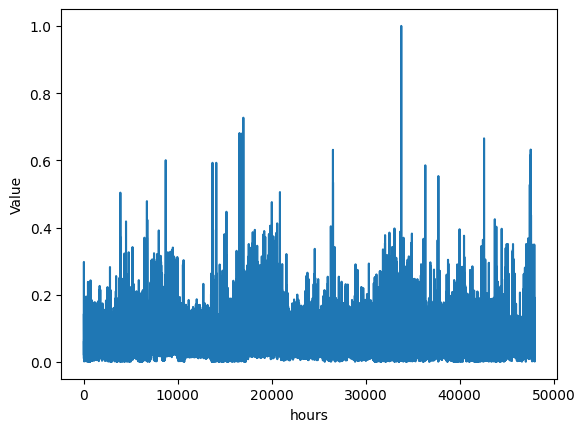

In [3]:
path="Models/M4/"

training_set = pd.read_csv('./Datasets/M4-Dataset/Train/Monthly-train.csv')

training_set = training_set.iloc[:,1:2] #electricity values in time
any_missing_train = training_set.isnull().any()
print("Any missing value:",any_missing_train)
print("all training set length: ",len(training_set))

sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)

plotting.plot_dataset(training_set, x_axis="hours", y_axis="Value")

## Load and plot test

Any missing value: V2    False
dtype: bool
all testing set length:  48000


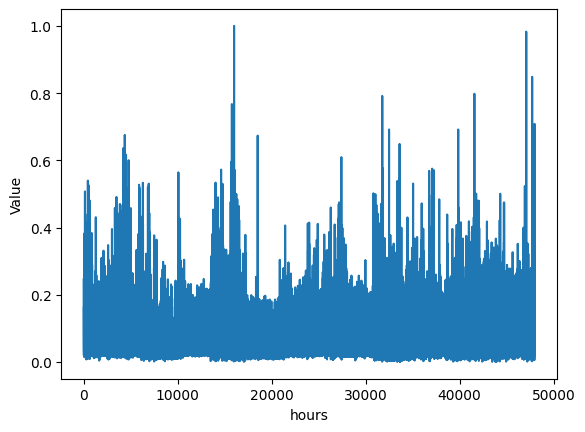

In [4]:
testing_set = pd.read_csv('./Datasets/M4-Dataset/Test/Monthly-test.csv')

testing_set = testing_set.iloc[:,1:2] #electricity values in time
any_missing_test = testing_set.isnull().any()
print("Any missing value:",any_missing_train)
print("all testing set length: ",len(testing_set))

sc = MinMaxScaler()
testing_set = sc.fit_transform(testing_set)

plotting.plot_dataset(testing_set, x_axis="hours", y_axis="Value")

## Create sequences for train

In [5]:
seq_length = 512 #it is tau in the paper

train_set=training_set[:42500]
print("train_set.shape:",train_set.shape)

x_train, y_train = utils.sliding_windows(train_set, seq_length)
trainX=torch.Tensor(np.array(x_train))
print("trainX.shape:",trainX.shape)
size=trainX.size(0)

sequences_train=utils.real_seq(training_set,seq_length)
sequences_train=sequences_train[:size]

sequences_train=torch.Tensor(sequences_train)
sequences_train.unsqueeze(0).unsqueeze(1)
sequences_train=sequences_train.permute(0,2,1)
print("Sequences_train.shape",sequences_train.shape)

train_set.shape: (42500, 1)
trainX.shape: torch.Size([41987, 512, 1])
Sequences_train.shape torch.Size([41987, 1, 512])


## Create sequences for test

In [6]:
test_set=testing_set[:42500]
print(test_set.shape)

x_test, y_test= utils.sliding_windows(test_set, seq_length)
testX=torch.Tensor(np.array(x_test))
print("testX.shape:",testX.shape)
size=testX.size(0)

sequences_test=utils.real_seq(testing_set,seq_length)
sequences_test=sequences_test[:size]

sequences_test=torch.Tensor(sequences_test)
sequences_test.unsqueeze(0).unsqueeze(1)
sequences_test=sequences_test.permute(0,2,1)
print("Sequences_test.shape",sequences_test.shape)

(42500, 1)
testX.shape: torch.Size([41987, 512, 1])
Sequences_test.shape torch.Size([41987, 1, 512])


### Test loader for evaluations

In [7]:
test= TensorDataset(testX, sequences_test)
test_loader = DataLoader(test, batch_size=347, shuffle=False)
embedder=torch.load("Models/Embedder/embedder_model.pt")

In [8]:
utils.create_folder(path)

Directory already exists: Models/M4/


## PSA-GAN

Cuda enabled: using GPU
Directory already exists: Models/M4/PSA-GAN/

Starting training: PSA-GAN
Total Epochs: 12 
Blocks to add with fade: 2
Timestamp to add blocks: 4
Fade-in True
ML True
SA True

[Epoch 1/12] [Batch 1/121] [D loss: 1.298246] [G loss: 1.455521] [Fade-in: 1.000000] [FID: 0.000212]
Improvement-Detected, model saved
[Epoch 1/12] [Batch 2/121] [D loss: 1.297135] [G loss: 1.423798] [Fade-in: 1.000000] [FID: 0.000112]
Improvement-Detected, model saved
[Epoch 1/12] [Batch 3/121] [D loss: 1.295776] [G loss: 1.400376] [Fade-in: 1.000000] [FID: 0.000188]
Improvement-Detected, model saved
[Epoch 1/12] [Batch 4/121] [D loss: 1.294407] [G loss: 1.392939] [Fade-in: 1.000000] [FID: 0.000199]
Improvement-Detected, model saved
[Epoch 1/12] [Batch 5/121] [D loss: 1.293033] [G loss: 1.392526] [Fade-in: 1.000000] [FID: 0.000149]
Improvement-Detected, model saved
[Epoch 1/12] [Batch 6/121] [D loss: 1.291656] [G loss: 1.379653] [Fade-in: 1.000000] [FID: 0.000243]
Improvement-Detected, mod

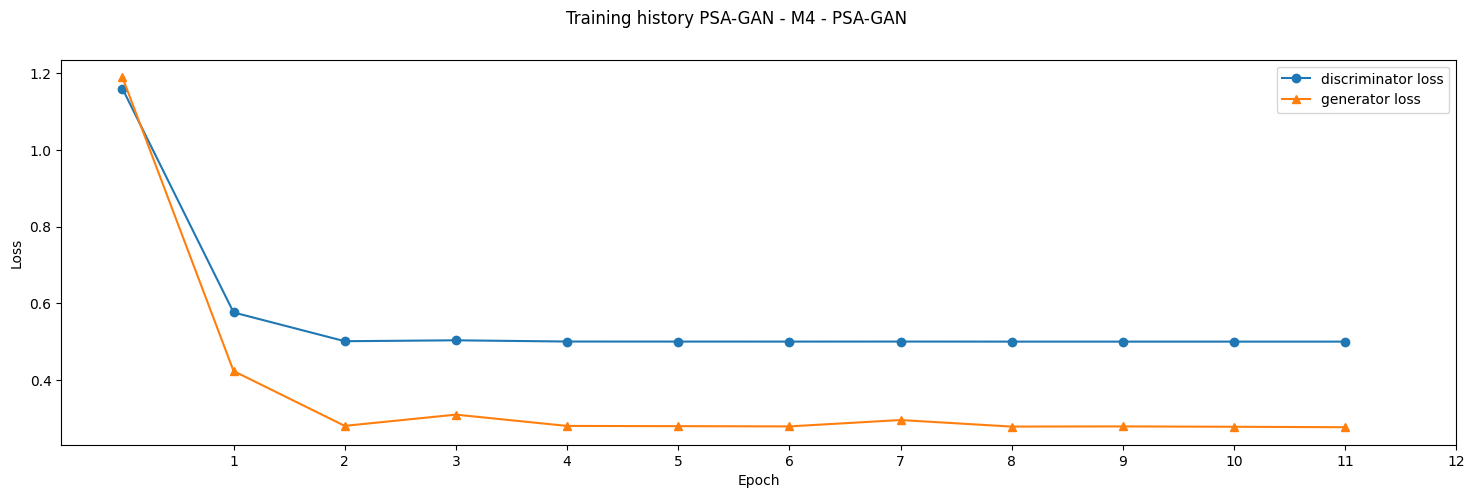

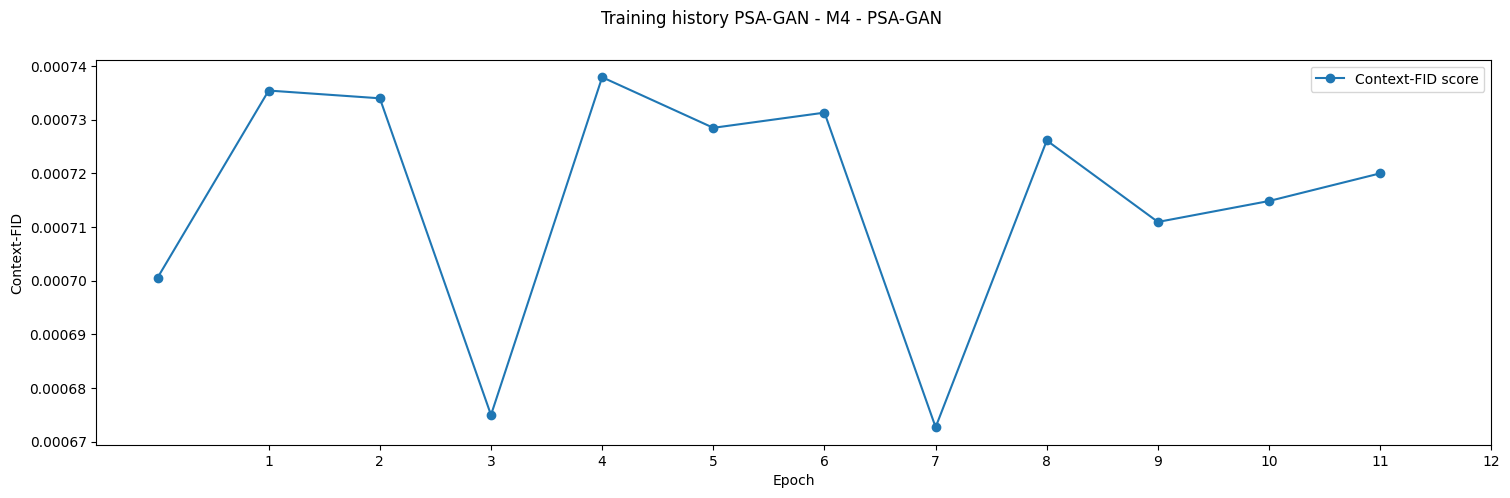

In [9]:
%%time

name_model="PSA-GAN"
D,G, d_losses, g_losses, fids = train.train_GAN(
    trainX,
    sequences_train,
    seq_length=seq_length,
    batch_size=347,
    discriminator_lr=0.0005,
    generator_lr=0.0005,
    num_epochs=12,
    blocks_to_add=2,
    timestamp=4,
    ml=True,
    fade_in=True,
    sa=True,
    save=True,
    name=name_model,
    gpu=True,
    path=path,
)

100%|██████████| 121/121 [00:03<00:00, 31.51it/s]


PSA-GAN  NRMSE: 0.000688481202814728


100%|██████████| 121/121 [00:47<00:00,  2.55it/s]

PSA-GAN  FID = 3.481106128659799e-06 +- 3.481106128659799e-06  
std: 0.0
NRMSE on test set:  tensor(0.2463)


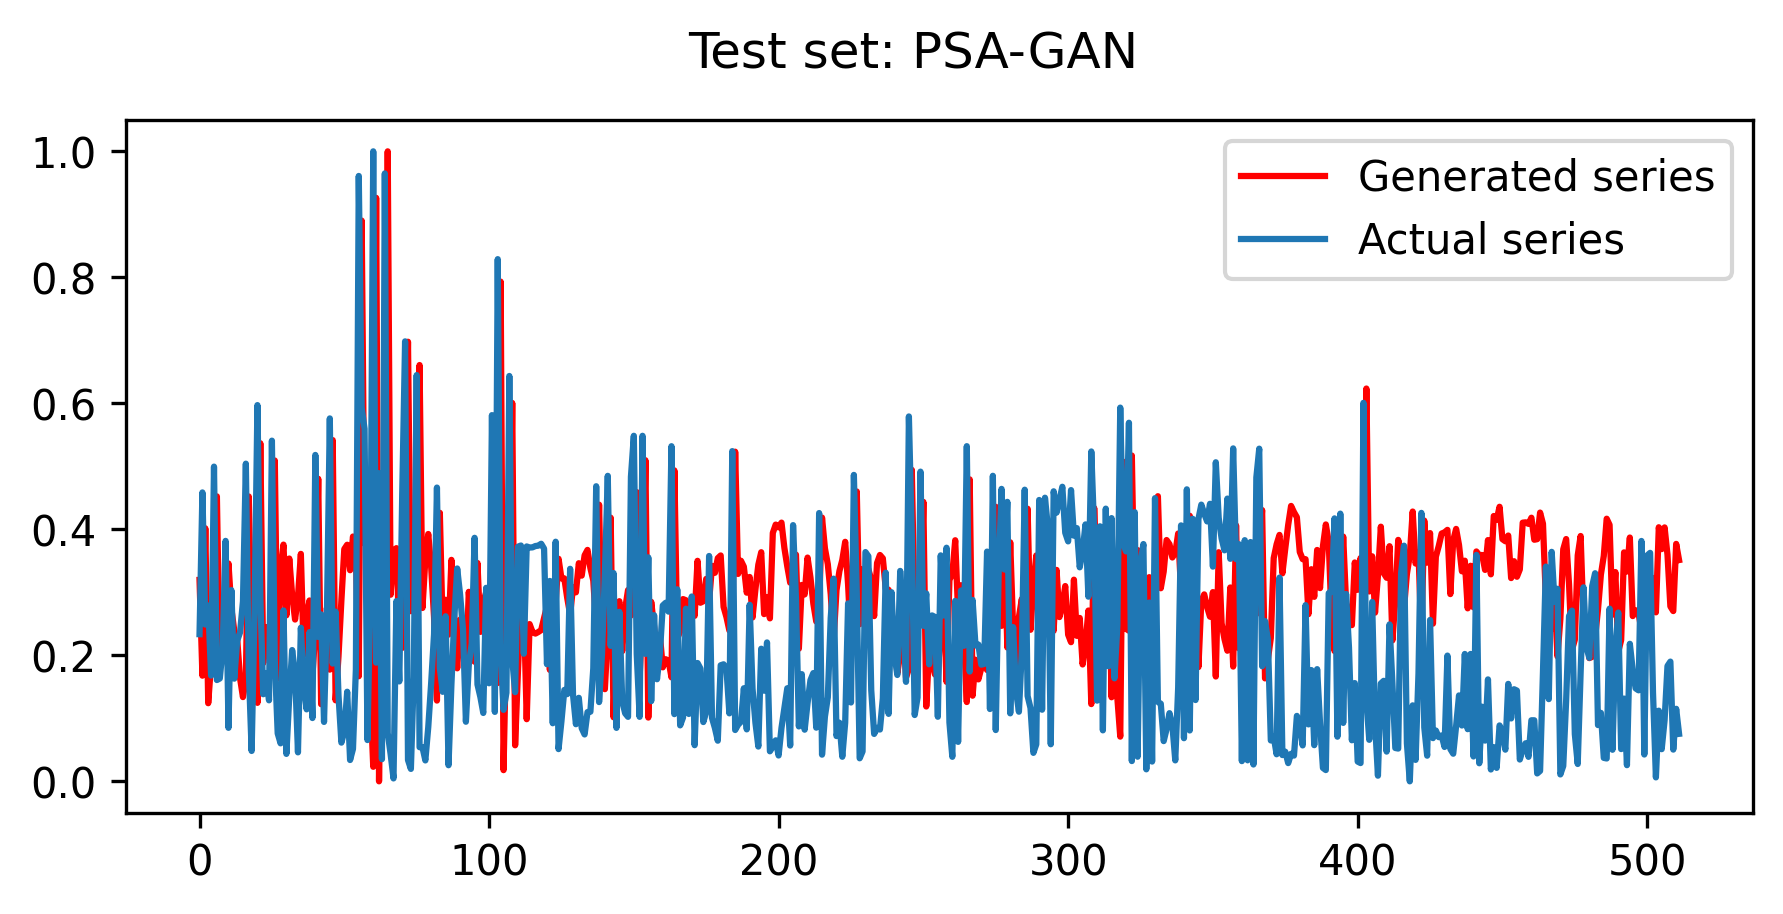

In [10]:
nrmse= metrics.evaluate_model(G,test_loader, "NRMSE")
print(name_model," NRMSE:",nrmse)

#mean, std_dev, lower, upper = metrics.run_evaluation(G,G,G, test_loader, "FID",0.95, embedder)
mean, std_dev, lower, upper = metrics.run_evaluation1(G, test_loader, "FID", 0.95, embedder)
print(name_model," FID =",mean,"+-",upper," \nstd:",std_dev)

plotting.prediction_test(seq_length, 347, test_set, testX, G, name_model)

In [11]:
utils.free_gpu(G)

## w/o Fade-in

Cuda enabled: using GPU
Directory already exists: Models/M4/wo_fade/

Starting training: wo_fade
Total Epochs: 12 
Blocks to add with fade: 2
Timestamp to add blocks: 4
Fade-in False
ML True
SA True

[Epoch 1/12] [Batch 1/121] [D loss: 1.468481] [G loss: 1.742513] [Fade-in: 1.000000] [FID: 0.000335]
Improvement-Detected, model saved
[Epoch 1/12] [Batch 2/121] [D loss: 1.467105] [G loss: 1.687117] [Fade-in: 1.000000] [FID: 0.000221]
Improvement-Detected, model saved
[Epoch 1/12] [Batch 3/121] [D loss: 1.465605] [G loss: 1.656692] [Fade-in: 1.000000] [FID: 0.000204]
Improvement-Detected, model saved
[Epoch 1/12] [Batch 4/121] [D loss: 1.464100] [G loss: 1.631422] [Fade-in: 1.000000] [FID: 0.000197]
Improvement-Detected, model saved
[Epoch 1/12] [Batch 5/121] [D loss: 1.462589] [G loss: 1.630209] [Fade-in: 1.000000] [FID: 0.000168]
Improvement-Detected, model saved
[Epoch 1/12] [Batch 6/121] [D loss: 1.461072] [G loss: 1.617485] [Fade-in: 1.000000] [FID: 0.000208]
Improvement-Detected, mo

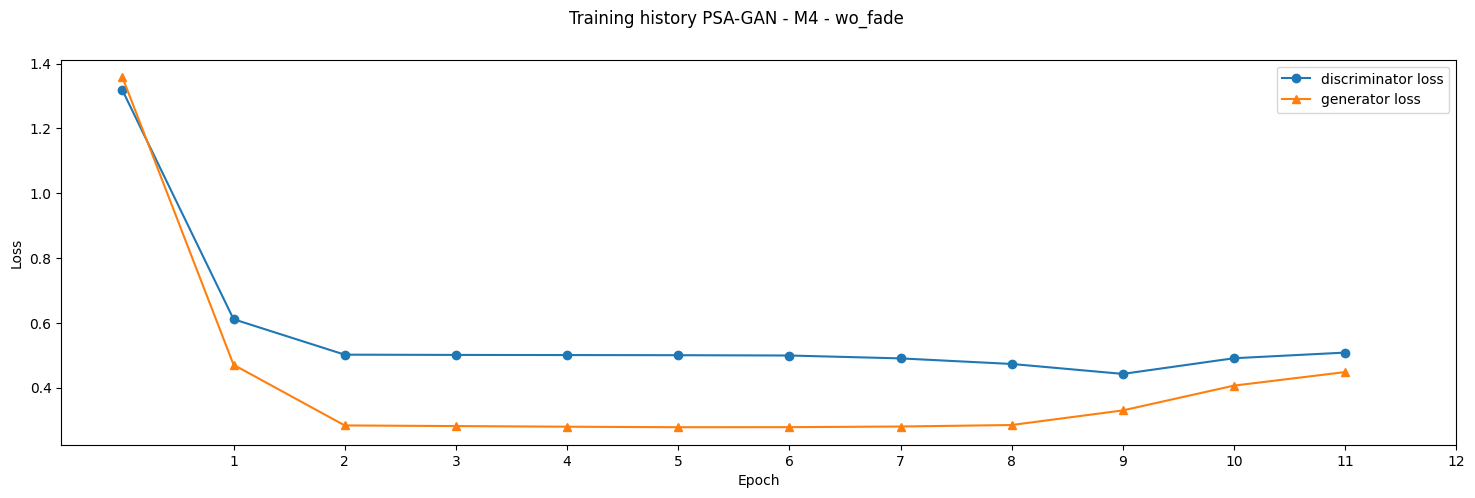

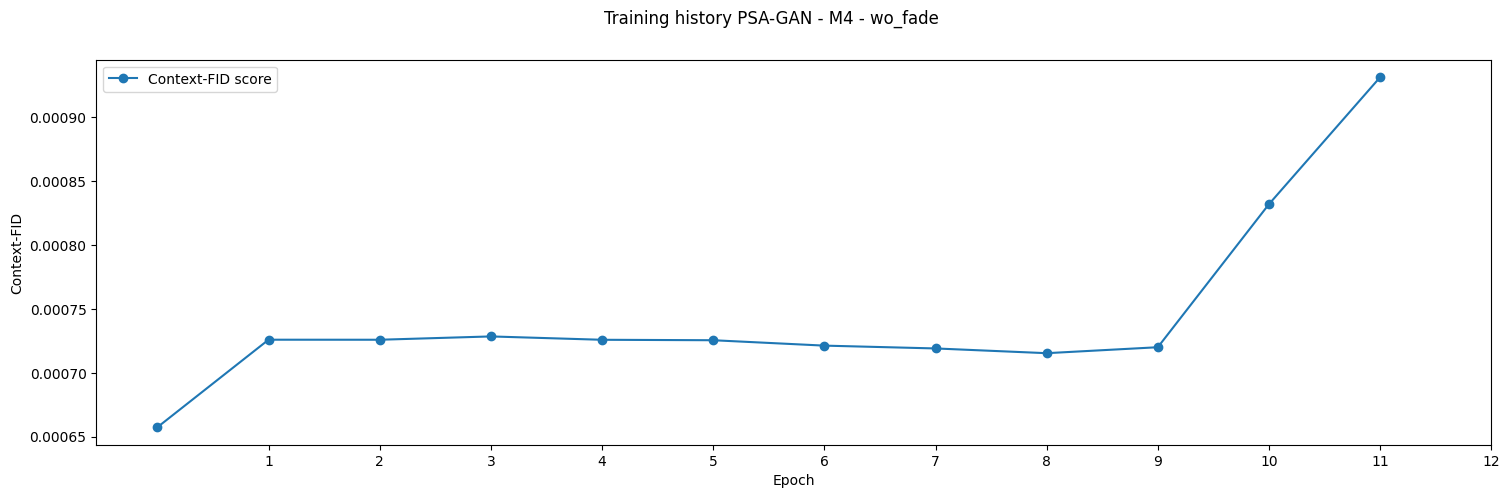

In [12]:
%%time

name_model="wo_fade"
D,G, d_losses, g_losses, fids = train.train_GAN(
    trainX,
    sequences_train,
    seq_length=seq_length,
    batch_size=347,
    discriminator_lr=0.0005,
    generator_lr=0.0005,
    num_epochs=12,
    blocks_to_add=2,
    timestamp=4,
    ml=True,
    fade_in=False,
    sa=True,
    save=True,
    name=name_model,
    gpu=True,
    path=path,
)

100%|██████████| 121/121 [00:03<00:00, 32.12it/s]


wo_fade  NRMSE: 0.05113917216658592


100%|██████████| 121/121 [00:48<00:00,  2.51it/s]

FID = 0.0007524465333288796 +- 0.0007524465333288796  
std: 0.0
NRMSE on test set:  tensor(6.9241)


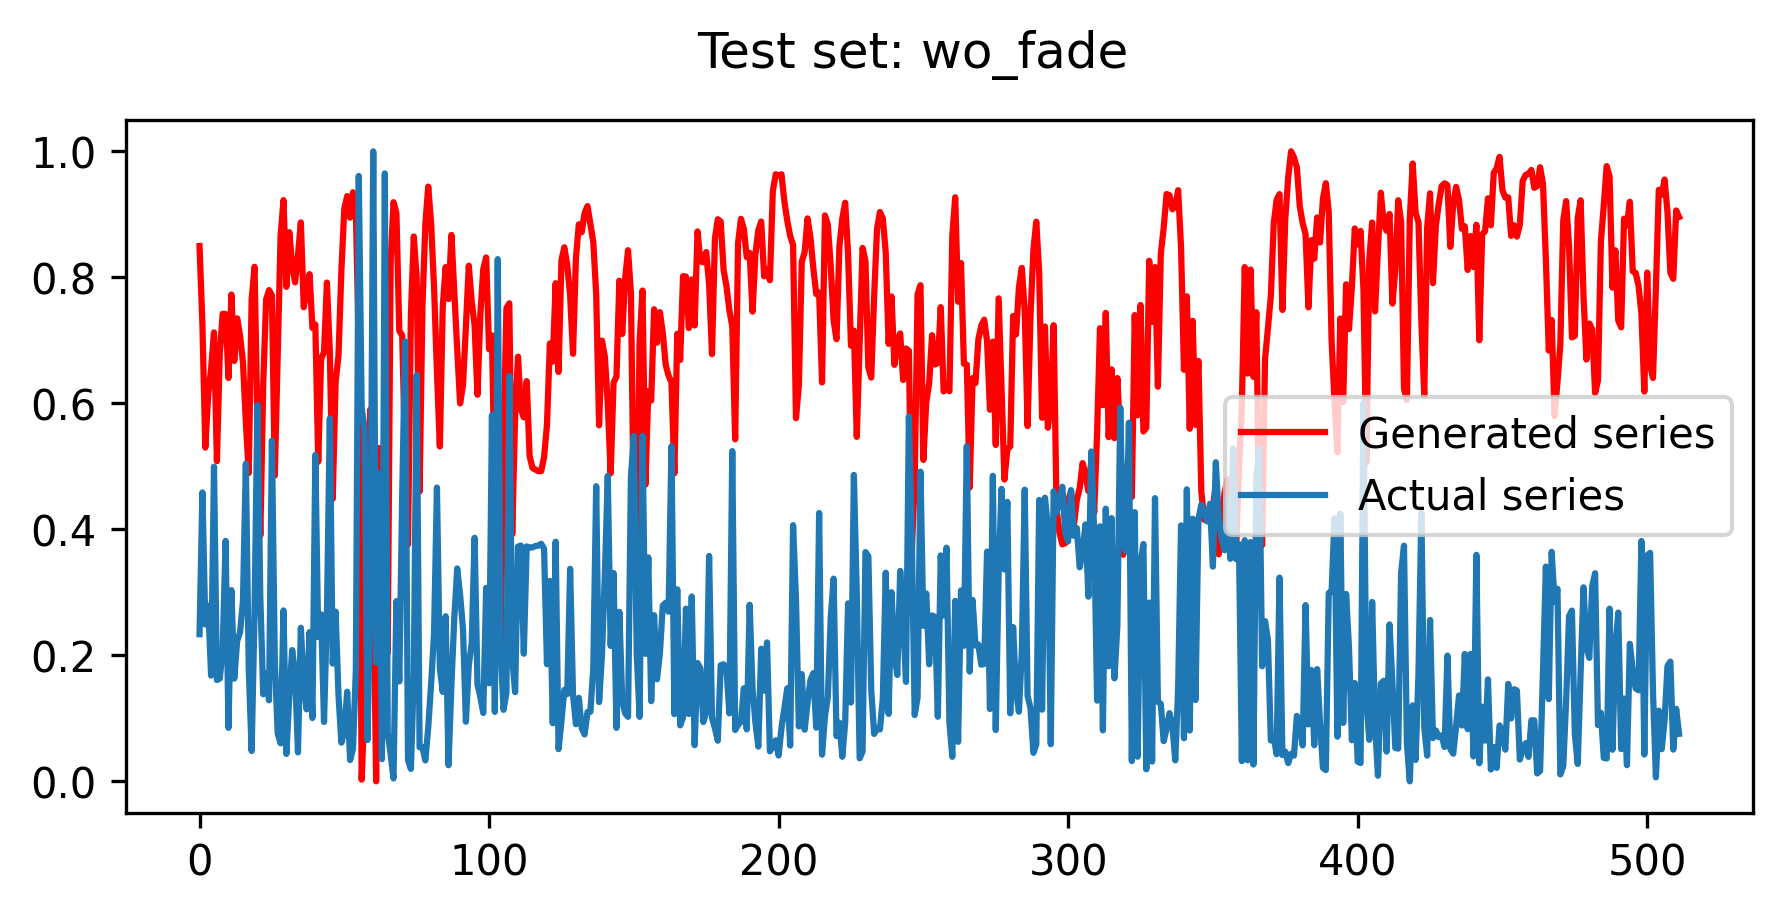

In [13]:

nrmse= metrics.evaluate_model(G,test_loader, "NRMSE")
print(name_model," NRMSE:",nrmse)

#mean, std_dev, lower, upper = metrics.run_evaluation(G,G,G, test_loader, "FID",0.95, embedder)
mean, std_dev, lower, upper = metrics.run_evaluation1(G, test_loader, "FID", 0.95, embedder)
print("FID =",mean,"+-",upper," \nstd:",std_dev)

plotting.prediction_test(seq_length, 347, test_set, testX, G, name_model)

In [14]:
utils.free_gpu(G)

## w/o  ML

Cuda enabled: using GPU
Directory already exists: Models/M4/wo_ml/

Starting training: wo_ml
Total Epochs: 12 
Blocks to add with fade: 2
Timestamp to add blocks: 4
Fade-in True
ML False
SA True

[Epoch 1/12] [Batch 1/121] [D loss: 1.317041] [G loss: 1.296458] [Fade-in: 1.000000] [FID: 0.000581]
Improvement-Detected, model saved
[Epoch 1/12] [Batch 2/121] [D loss: 1.315672] [G loss: 1.295246] [Fade-in: 1.000000] [FID: 0.000424]
Improvement-Detected, model saved
[Epoch 1/12] [Batch 3/121] [D loss: 1.314314] [G loss: 1.294036] [Fade-in: 1.000000] [FID: 0.000464]
Improvement-Detected, model saved
[Epoch 1/12] [Batch 4/121] [D loss: 1.312958] [G loss: 1.292827] [Fade-in: 1.000000] [FID: 0.000459]
Improvement-Detected, model saved
[Epoch 1/12] [Batch 5/121] [D loss: 1.311604] [G loss: 1.291618] [Fade-in: 1.000000] [FID: 0.000371]
Improvement-Detected, model saved
[Epoch 1/12] [Batch 6/121] [D loss: 1.310249] [G loss: 1.290410] [Fade-in: 1.000000] [FID: 0.000427]
Improvement-Detected, model 

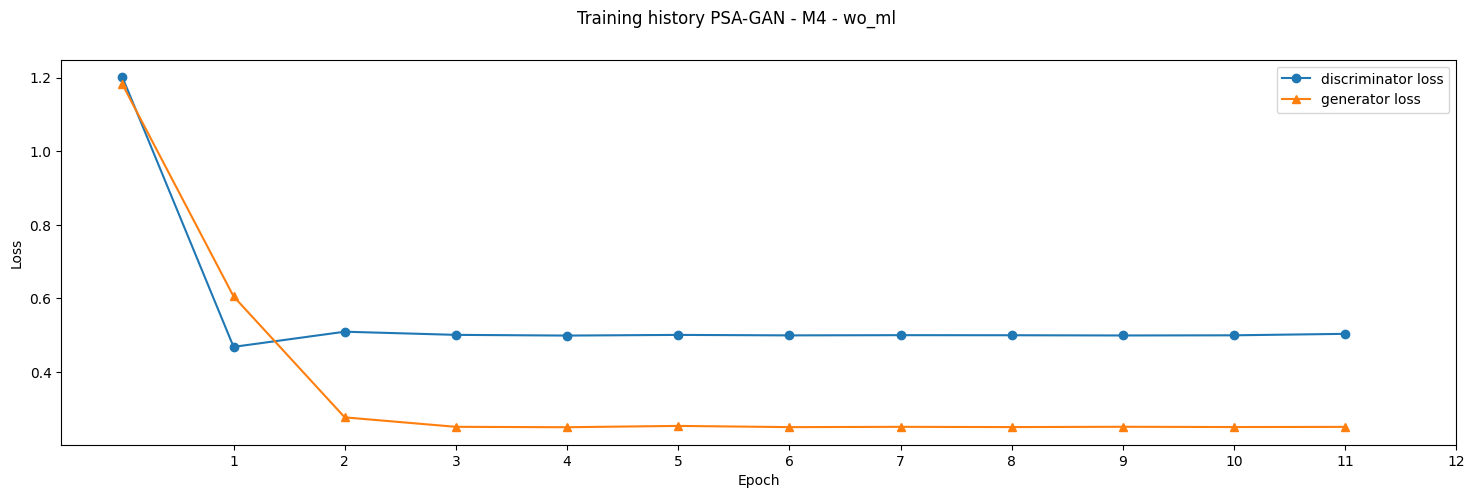

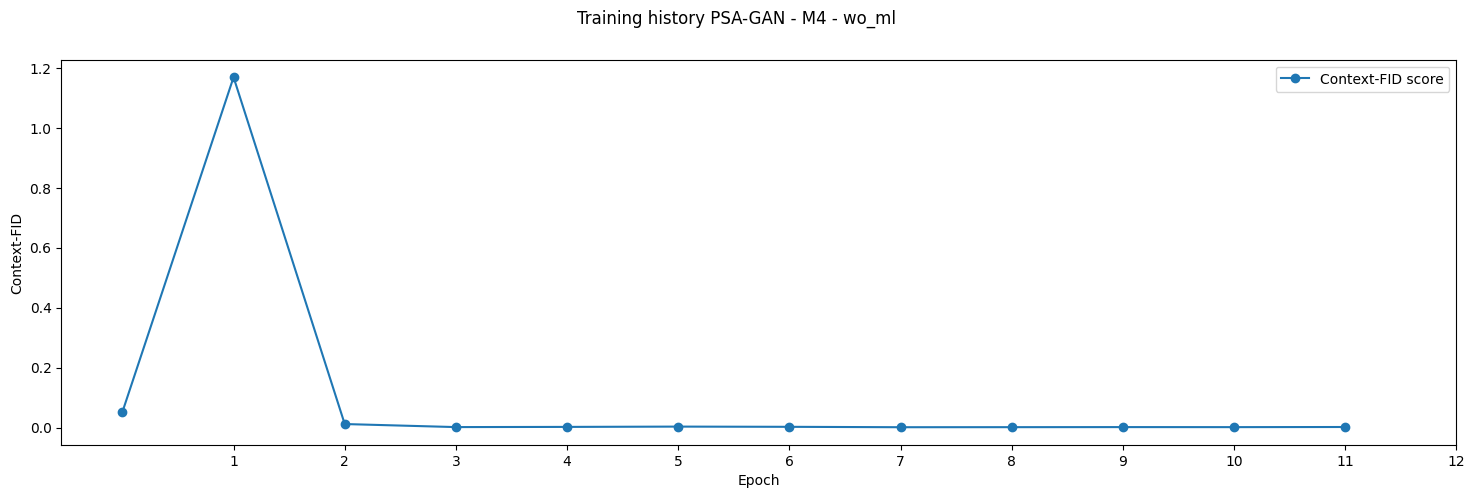

In [15]:
%%time

name_model="wo_ml"
D,G, d_losses, g_losses, fids = train.train_GAN(
    trainX,
    sequences_train,
    seq_length=seq_length,
    batch_size=347,
    discriminator_lr=0.0005,
    generator_lr=0.0005,
    num_epochs=12,
    blocks_to_add=2,
    timestamp=4,
    ml=False,
    fade_in=True,
    sa=True,
    save=True,
    name=name_model,
    gpu=True,
    path=path,
)

100%|██████████| 121/121 [00:03<00:00, 30.80it/s]


wo_ml  NRMSE: 0.004171094857156277


100%|██████████| 121/121 [00:50<00:00,  2.41it/s]

FID = 8.583649214861924e-06 +- 8.583649214861924e-06  
std: 0.0
NRMSE on test set:  tensor(0.4767)


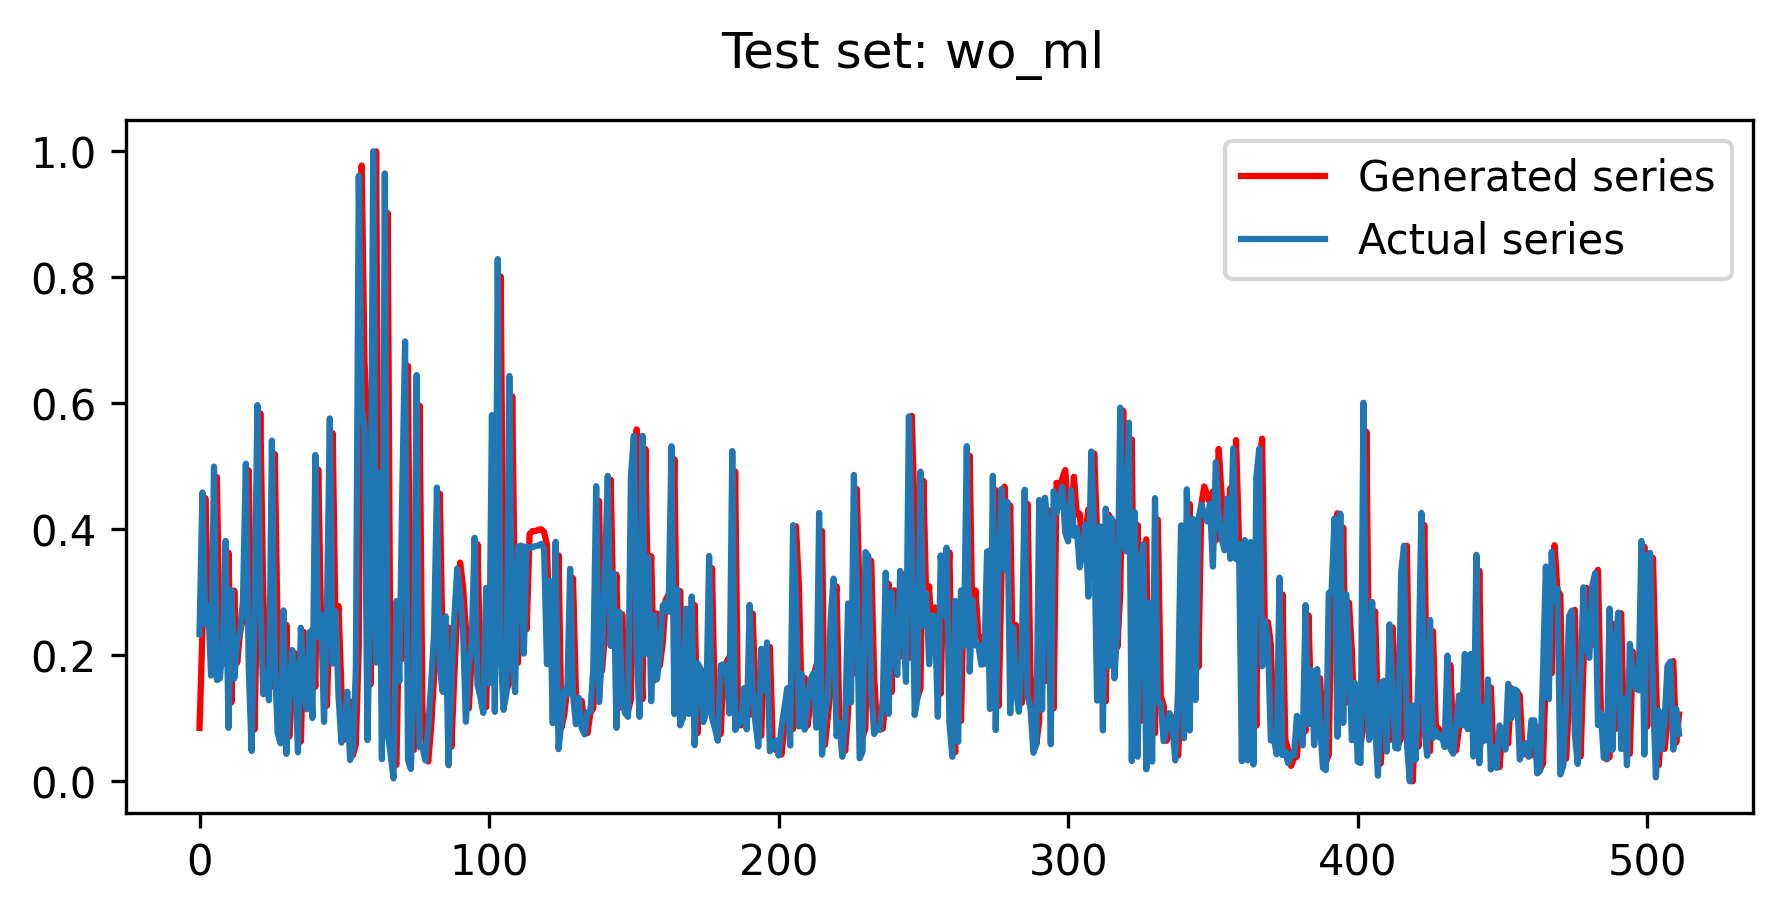

In [16]:

nrmse= metrics.evaluate_model(G,test_loader, "NRMSE")
print(name_model," NRMSE:",nrmse)

#mean, std_dev, lower, upper = metrics.run_evaluation(G,G,G, test_loader, "FID",0.95, embedder)
mean, std_dev, lower, upper = metrics.run_evaluation1(G, test_loader, "FID", 0.95, embedder)
print("FID =",mean,"+-",upper," \nstd:",std_dev)

plotting.prediction_test(seq_length, 347, test_set, testX, G, name_model)

In [17]:
utils.free_gpu(G)

## w/o  ML and Fade-in

Cuda enabled: using GPU
New models directory created!: Models/M4/wo_ml_fade/

Starting training: wo_ml_fade
Total Epochs: 12 
Blocks to add with fade: 2
Timestamp to add blocks: 4
Fade-in False
ML False
SA True
[Epoch 1/12] [Batch 1/121] [D loss: 0.690900] [G loss: 0.613380] [Fade-in: 1.000000] [FID: 0.001545]
Improvement-Detected, model saved
[Epoch 1/12] [Batch 2/121] [D loss: 0.660763] [G loss: 0.600553] [Fade-in: 1.000000] [FID: 0.001309]
Improvement-Detected, model saved
[Epoch 1/12] [Batch 3/121] [D loss: 0.651820] [G loss: 0.588482] [Fade-in: 1.000000] [FID: 0.001413]
Improvement-Detected, model saved
[Epoch 1/12] [Batch 4/121] [D loss: 0.643355] [G loss: 0.576529] [Fade-in: 1.000000] [FID: 0.001504]
Improvement-Detected, model saved
[Epoch 1/12] [Batch 5/121] [D loss: 0.635104] [G loss: 0.564738] [Fade-in: 1.000000] [FID: 0.001458]
Improvement-Detected, model saved
[Epoch 1/12] [Batch 6/121] [D loss: 0.627101] [G loss: 0.552975] [Fade-in: 1.000000] [FID: 0.001580]
Improvement-D

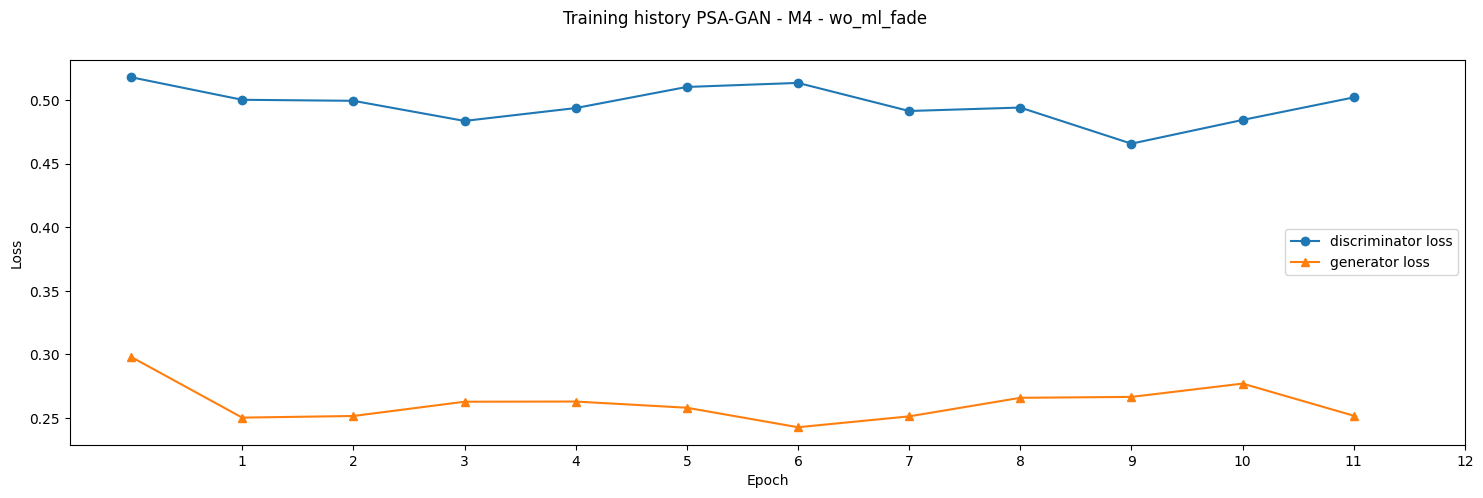

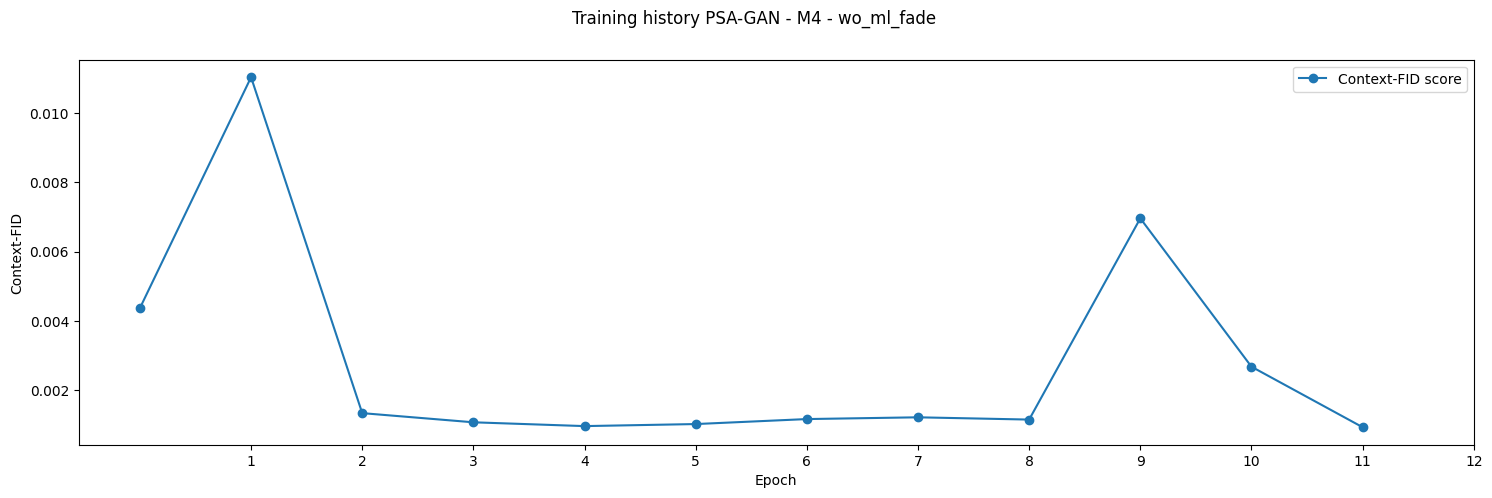

In [17]:
%%time

name_model="wo_ml_fade"
D,G, d_losses, g_losses, fids = train.train_GAN(
    trainX,
    sequences_train,
    seq_length=seq_length,
    batch_size=347,
    discriminator_lr=0.0005,
    generator_lr=0.0005,
    num_epochs=12,
    blocks_to_add=2,
    timestamp=4,
    ml=False,
    fade_in=False,
    sa=True,
    save=True,
    name=name_model,
    gpu=True,
    path=path,
)

100%|██████████| 121/121 [00:05<00:00, 22.45it/s]


wo_ml_fade  NRMSE: 10.765485763549805


100%|██████████| 121/121 [01:14<00:00,  1.62it/s]

FID = 0.016477271695804485 +- 0.016477271695804485  
std: 0.0
NRMSE on test set:  tensor(1477.6099)


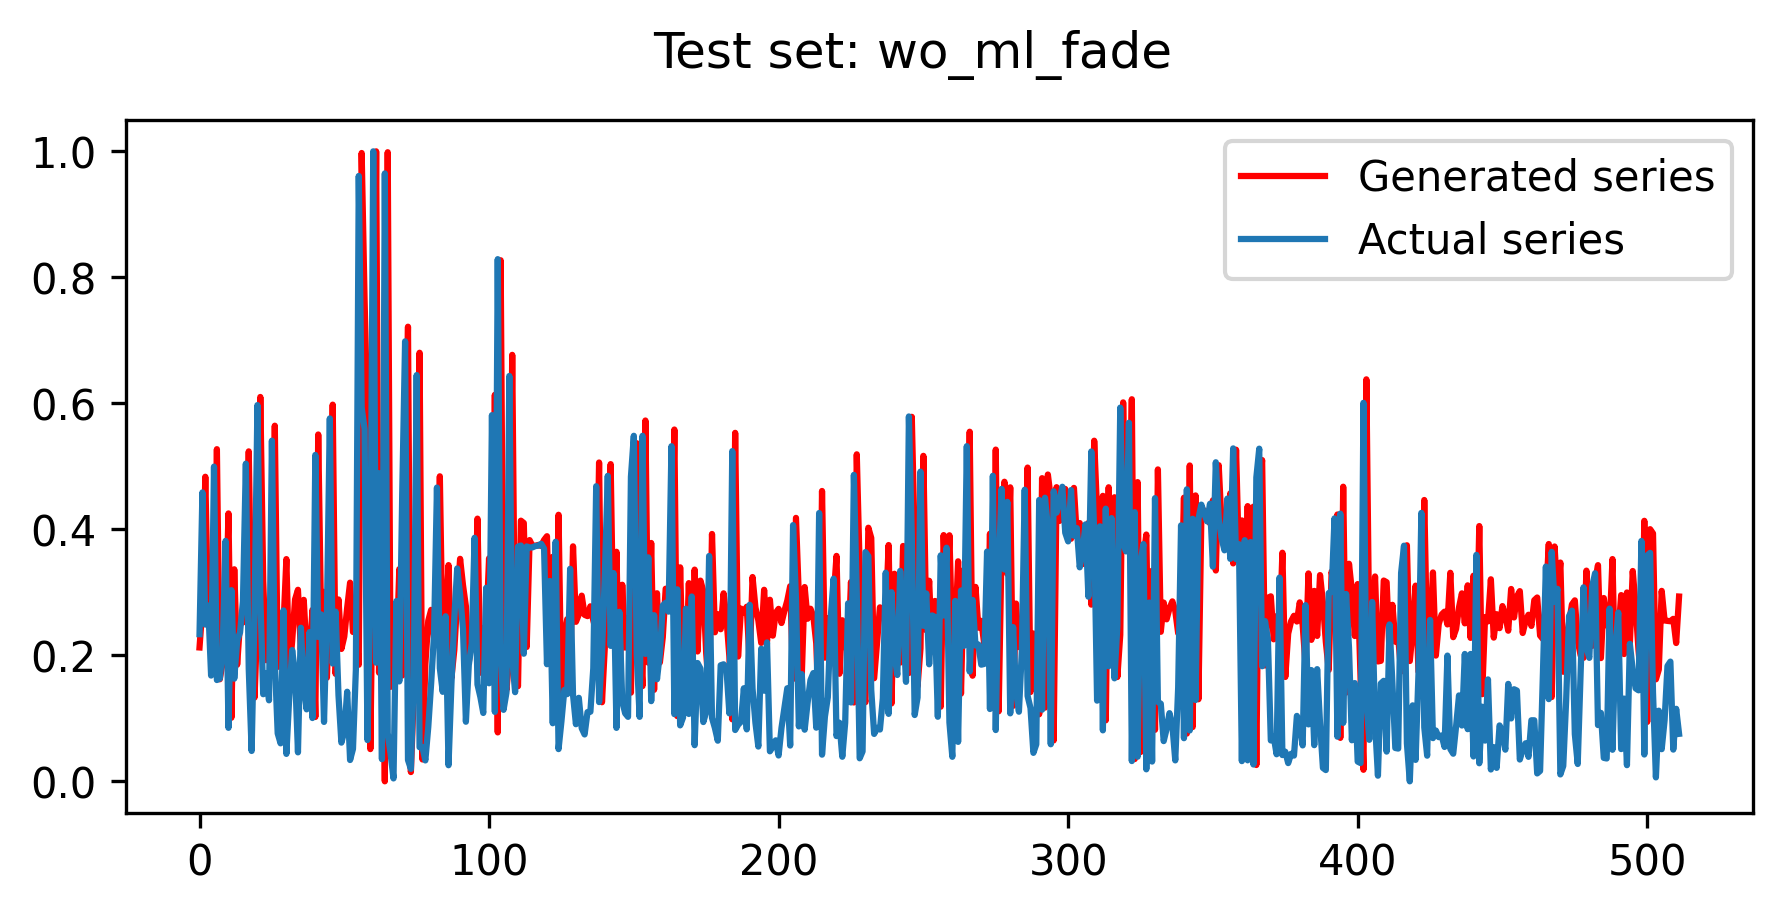

In [18]:
nrmse= metrics.evaluate_model(G,test_loader, "NRMSE")
print(name_model," NRMSE:",nrmse)

#mean, std_dev, lower, upper = metrics.run_evaluation(G,G,G, test_loader, "FID",0.95, embedder)
mean, std_dev, lower, upper = metrics.run_evaluation1(G, test_loader, "FID", 0.95, embedder)
print("FID =",mean,"+-",upper," \nstd:",std_dev)

plotting.prediction_test(seq_length, 347, test_set, testX, G, name_model)

In [19]:
utils.free_gpu(G)

## w/o SA

Cuda enabled: using GPU
Directory already exists: Models/M4/wo_sa/

Starting training: wo_sa
Total Epochs: 12 
Blocks to add with fade: 2
Timestamp to add blocks: 4
Fade-in True
ML True
SA False

[Epoch 1/12] [Batch 1/121] [D loss: 1.913842] [G loss: 2.070417] [Fade-in: 1.000000] [FID: 0.000267]
Improvement-Detected, model saved
[Epoch 1/12] [Batch 2/121] [D loss: 1.911822] [G loss: 2.004649] [Fade-in: 1.000000] [FID: 0.000149]
Improvement-Detected, model saved
[Epoch 1/12] [Batch 3/121] [D loss: 1.909967] [G loss: 1.971191] [Fade-in: 1.000000] [FID: 0.000178]
Improvement-Detected, model saved
[Epoch 1/12] [Batch 4/121] [D loss: 1.908123] [G loss: 1.944788] [Fade-in: 1.000000] [FID: 0.000184]
Improvement-Detected, model saved
[Epoch 1/12] [Batch 5/121] [D loss: 1.906287] [G loss: 1.924614] [Fade-in: 1.000000] [FID: 0.000142]
Improvement-Detected, model saved
[Epoch 1/12] [Batch 6/121] [D loss: 1.904459] [G loss: 1.913601] [Fade-in: 1.000000] [FID: 0.000225]
Improvement-Detected, model 

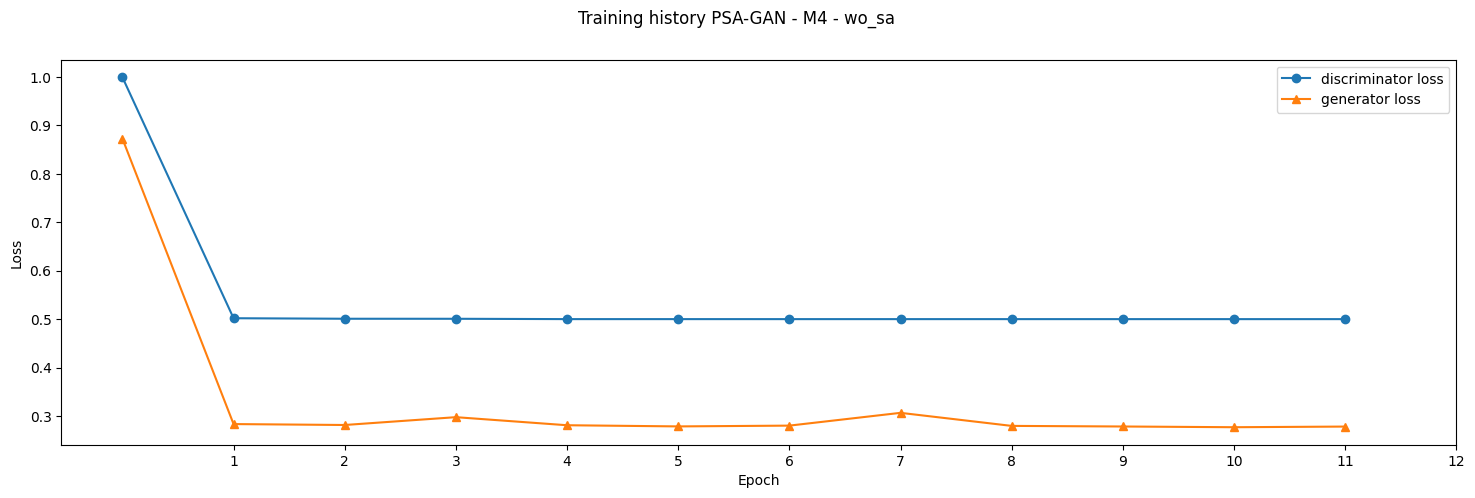

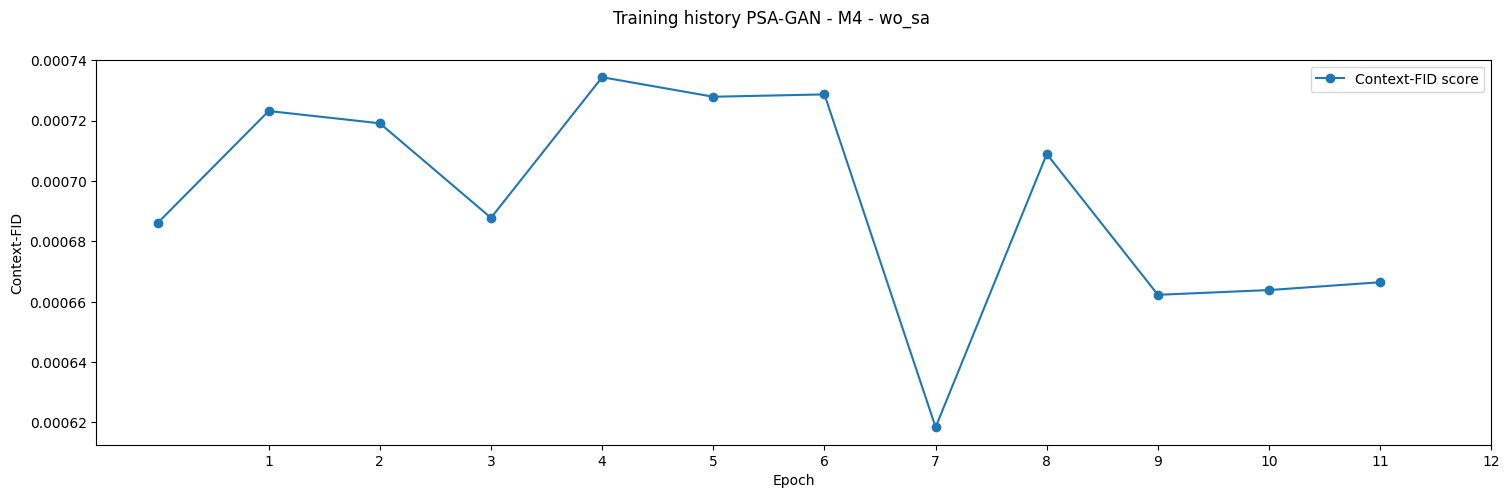

In [18]:
%%time

name_model="wo_sa"
D,G, d_losses, g_losses, fids = train.train_GAN(
    trainX,
    sequences_train,
    seq_length=seq_length,
    batch_size=347,
    discriminator_lr=0.0005,
    generator_lr=0.0005,
    num_epochs=12,
    blocks_to_add=2,
    timestamp=4,
    ml=True,
    fade_in=True,
    sa=False,
    save=True,
    name=name_model,
    gpu=True,
    path=path,
)


100%|██████████| 121/121 [00:02<00:00, 43.15it/s]


wo_sa  NRMSE: 0.0006485373596660793


100%|██████████| 121/121 [00:48<00:00,  2.50it/s]

FID = 3.215433457189822e-06 +- 3.215433457189822e-06  
std: 0.0
NRMSE on test set:  tensor(0.2371)


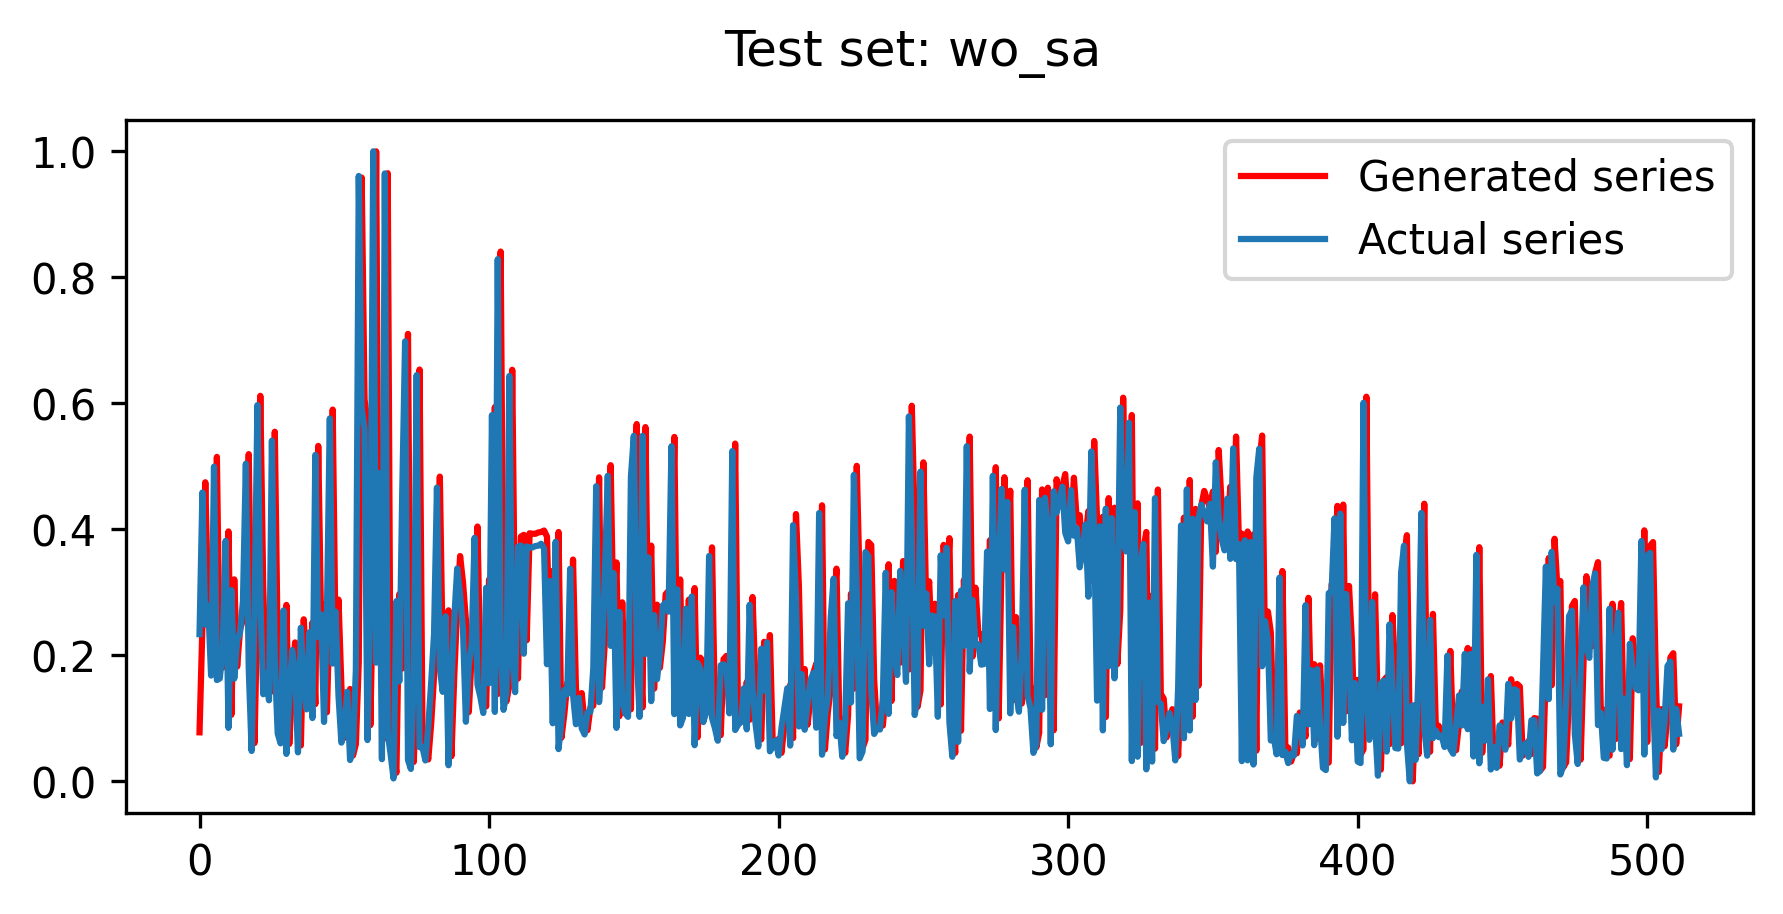

In [19]:
nrmse= metrics.evaluate_model(G,test_loader, "NRMSE")
print(name_model," NRMSE:",nrmse)

#mean, std_dev, lower, upper = metrics.run_evaluation(G,G,G, test_loader, "FID",0.95, embedder)
mean, std_dev, lower, upper = metrics.run_evaluation1(G, test_loader, "FID", 0.95, embedder)
print("FID =",mean,"+-",upper," \nstd:",std_dev)

plotting.prediction_test(seq_length, 347, test_set, testX, G, name_model)

In [20]:
utils.free_gpu(G)

## w/o SA and fade

Cuda enabled: using GPU
Directory already exists: Models/M4/wo_sa_fade/

Starting training: wo_sa_fade
Total Epochs: 12 
Blocks to add with fade: 2
Timestamp to add blocks: 4
Fade-in False
ML True
SA False

[Epoch 1/12] [Batch 1/121] [D loss: 0.722078] [G loss: 0.844993] [Fade-in: 1.000000] [FID: 0.000190]
Improvement-Detected, model saved
[Epoch 1/12] [Batch 2/121] [D loss: 0.700814] [G loss: 0.795988] [Fade-in: 1.000000] [FID: 0.000108]
Improvement-Detected, model saved
[Epoch 1/12] [Batch 3/121] [D loss: 0.697392] [G loss: 0.798005] [Fade-in: 1.000000] [FID: 0.000182]
[Epoch 1/12] [Batch 4/121] [D loss: 0.696726] [G loss: 0.792533] [Fade-in: 1.000000] [FID: 0.000200]
Improvement-Detected, model saved
[Epoch 1/12] [Batch 5/121] [D loss: 0.696072] [G loss: 0.785568] [Fade-in: 1.000000] [FID: 0.000153]
Improvement-Detected, model saved
[Epoch 1/12] [Batch 6/121] [D loss: 0.695423] [G loss: 0.768876] [Fade-in: 1.000000] [FID: 0.000249]
Improvement-Detected, model saved
[Epoch 1/12] [Bat

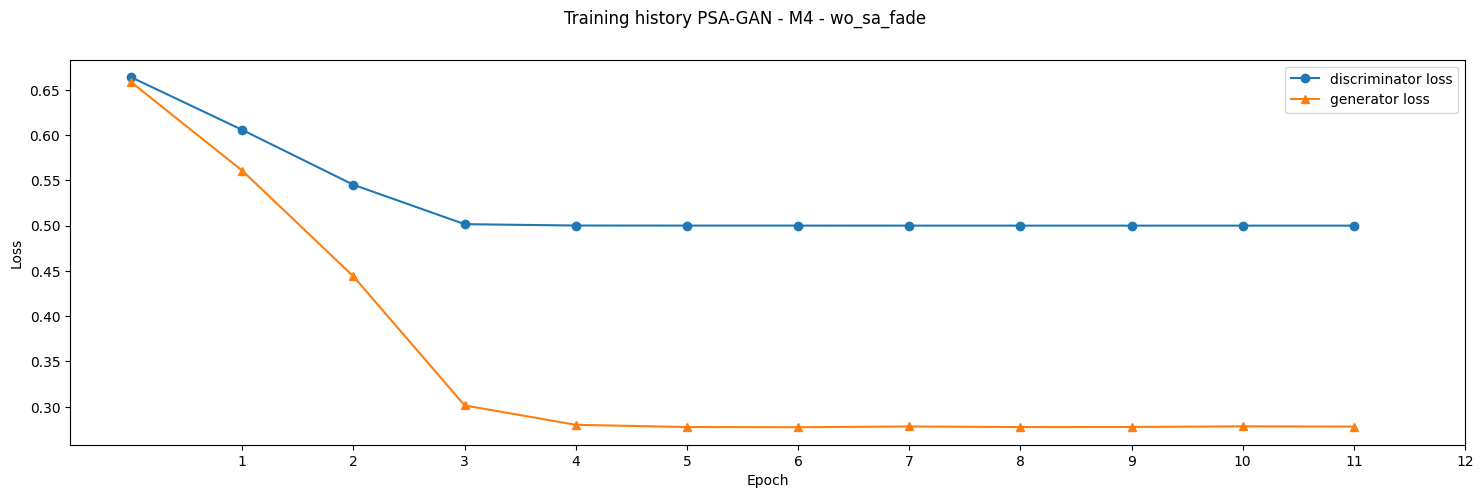

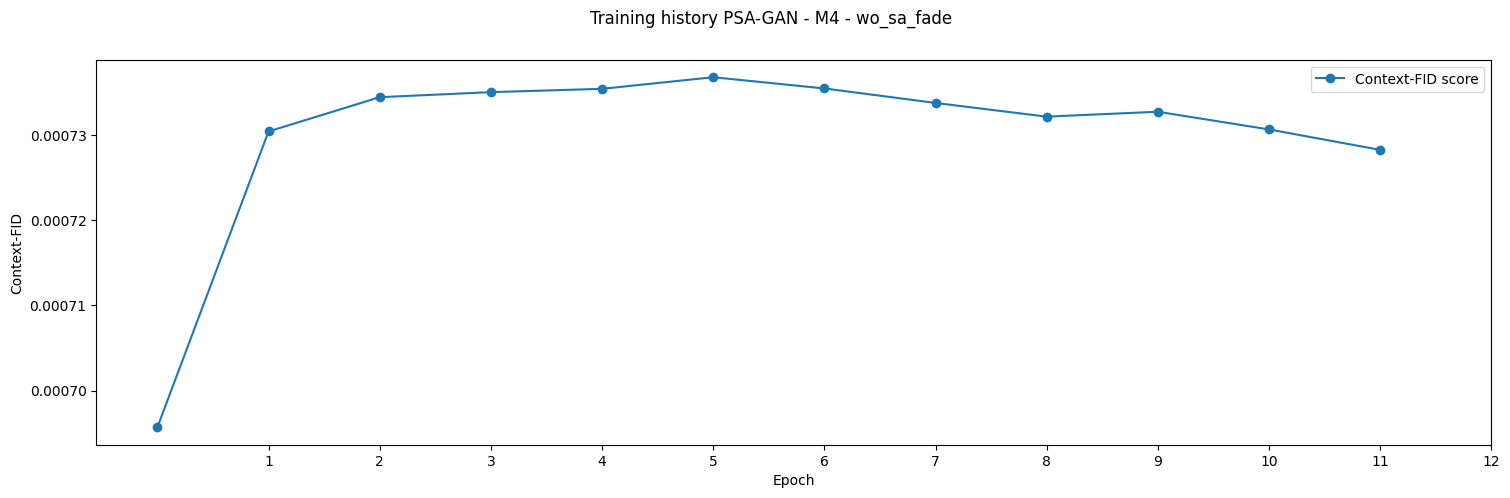

In [30]:
%%time

name_model="wo_sa_fade"
D,G, d_losses, g_losses, fids = train.train_GAN(
    trainX,
    sequences_train,
    seq_length=seq_length,
    batch_size=347,
    discriminator_lr=0.0005,
    generator_lr=0.0005,
    num_epochs=12,
    blocks_to_add=2,
    timestamp=4,
    ml=True,
    fade_in=False,
    sa=False,
    save=True,
    name=name_model,
    gpu=True,
    path=path,
)


100%|██████████| 121/121 [00:02<00:00, 46.73it/s]


wo_sa_fade  NRMSE: 0.033849410712718964


100%|██████████| 121/121 [00:43<00:00,  2.80it/s]

FID = 0.00033272068506205667 +- 0.00033272068506205667  
std: 0.0
NRMSE on test set:  tensor(4.6269)


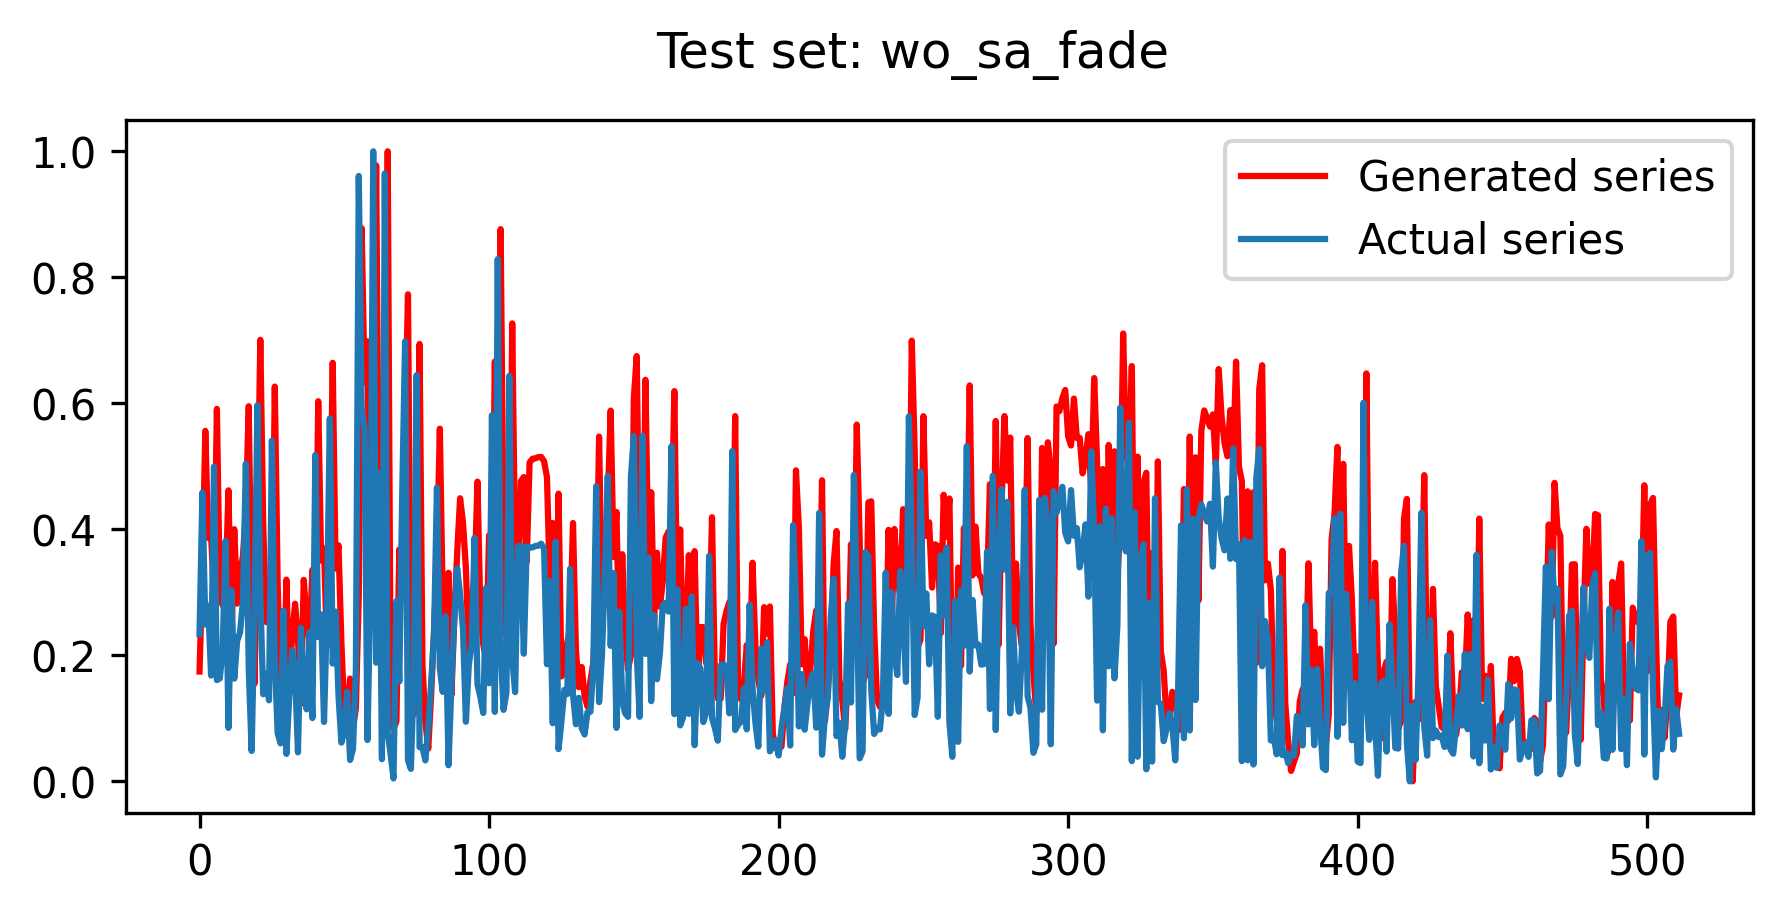

In [31]:
nrmse= metrics.evaluate_model(G,test_loader, "NRMSE")
print(name_model," NRMSE:",nrmse)

#mean, std_dev, lower, upper = metrics.run_evaluation(G,G,G, test_loader, "FID",0.95, embedder)
mean, std_dev, lower, upper = metrics.run_evaluation1(G, test_loader, "FID", 0.95, embedder)
print("FID =",mean,"+-",upper," \nstd:",std_dev)

plotting.prediction_test(seq_length, 347, test_set, testX, G, name_model)

In [32]:
utils.free_gpu(G)

## w/o SA and ML

Cuda enabled: using GPU
New models directory created!: Models/M4/wo_sa_ml/

Starting training: wo_sa_ml
Total Epochs: 12 
Blocks to add with fade: 2
Timestamp to add blocks: 4
Fade-in True
ML False
SA False

[Epoch 1/12] [Batch 1/121] [D loss: 1.521727] [G loss: 1.474236] [Fade-in: 1.000000] [FID: 0.000285]
Improvement-Detected, model saved
[Epoch 1/12] [Batch 2/121] [D loss: 1.520109] [G loss: 1.472909] [Fade-in: 1.000000] [FID: 0.000208]
Improvement-Detected, model saved
[Epoch 1/12] [Batch 3/121] [D loss: 1.518550] [G loss: 1.471589] [Fade-in: 1.000000] [FID: 0.000273]
Improvement-Detected, model saved
[Epoch 1/12] [Batch 4/121] [D loss: 1.516997] [G loss: 1.470271] [Fade-in: 1.000000] [FID: 0.000285]
Improvement-Detected, model saved
[Epoch 1/12] [Batch 5/121] [D loss: 1.515448] [G loss: 1.468956] [Fade-in: 1.000000] [FID: 0.000273]
Improvement-Detected, model saved
[Epoch 1/12] [Batch 6/121] [D loss: 1.513903] [G loss: 1.467645] [Fade-in: 1.000000] [FID: 0.000354]
Improvement-Dete

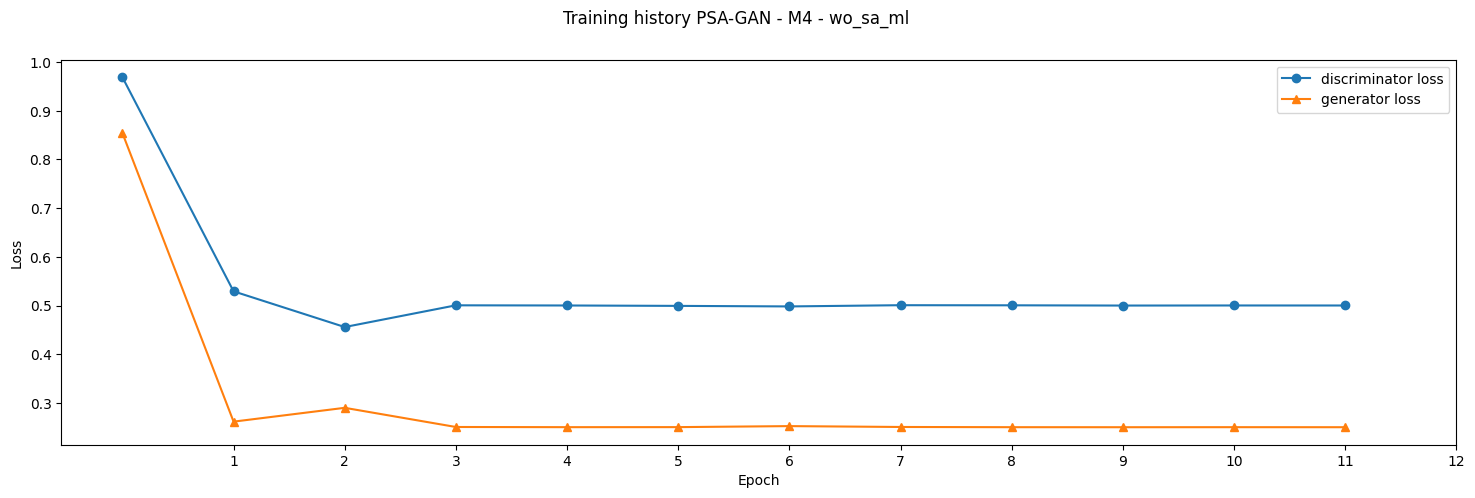

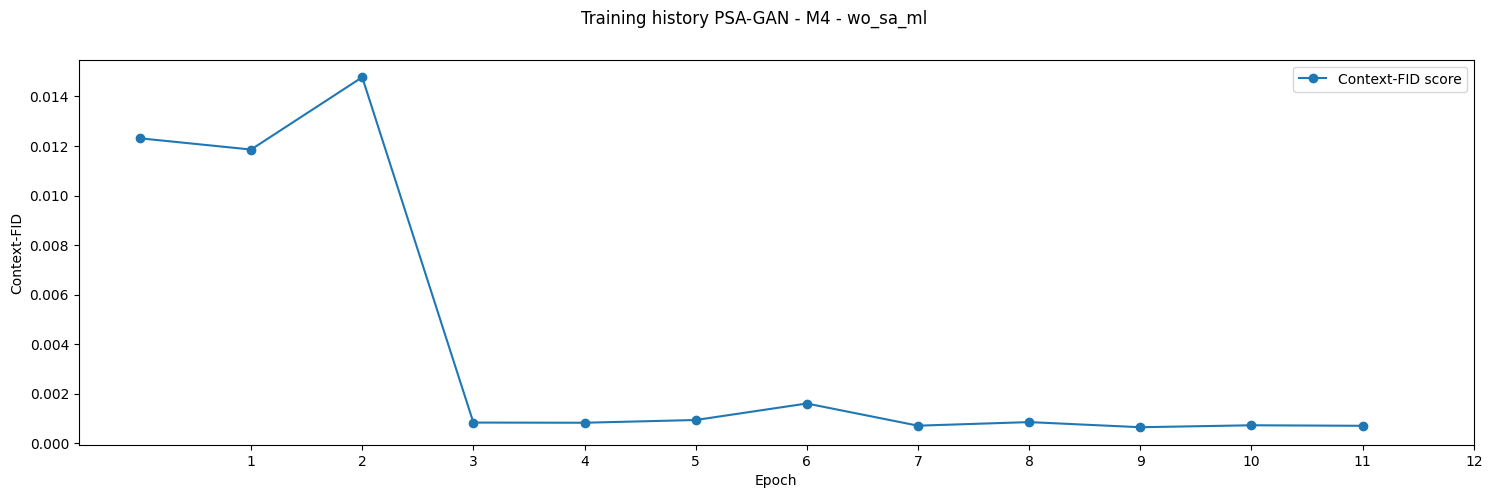

In [34]:
%%time

name_model="wo_sa_ml"
D,G, d_losses, g_losses, fids = train.train_GAN(
    trainX,
    sequences_train,
    seq_length=seq_length,
    batch_size=347,
    discriminator_lr=0.0005,
    generator_lr=0.0005,
    num_epochs=12,
    blocks_to_add=2,
    timestamp=4,
    ml=False,
    fade_in=True,
    sa=False,
    save=True,
    name=name_model,
    gpu=True,
    path=path,
)

100%|██████████| 121/121 [00:02<00:00, 43.24it/s]


wo_sa_ml  NRMSE: 0.001145888352766633


100%|██████████| 121/121 [00:49<00:00,  2.47it/s]

FID = 3.3149396216228918e-06 +- 3.3149396216228918e-06  
std: 0.0
NRMSE on test set:  tensor(0.1914)


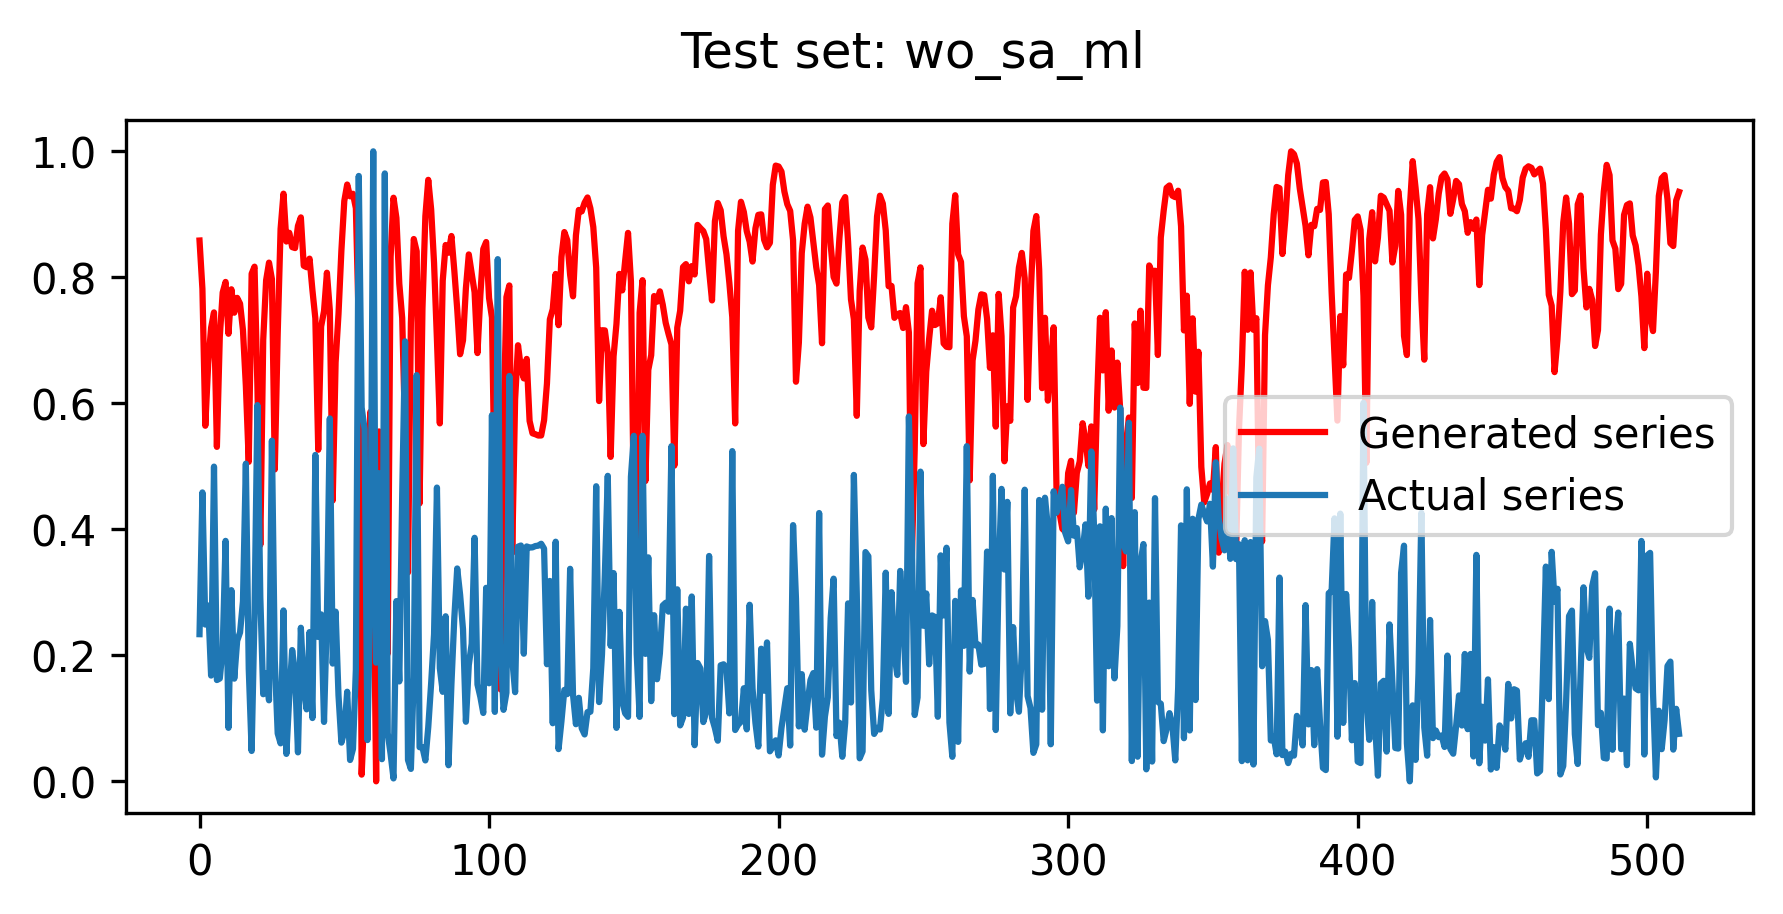

In [35]:
nrmse= metrics.evaluate_model(G,test_loader, "NRMSE")
print(name_model," NRMSE:",nrmse)

#mean, std_dev, lower, upper = metrics.run_evaluation(G,G,G, test_loader, "FID",0.95, embedder)
mean, std_dev, lower, upper = metrics.run_evaluation1(G, test_loader, "FID", 0.95, embedder)
print("FID =",mean,"+-",upper," \nstd:",std_dev)

plotting.prediction_test(seq_length, 347, test_set, testX, G, name_model)

In [36]:
utils.free_gpu(G)

## w/o SA and ML and Fade

Cuda enabled: using GPU
New models directory created!: Models/M4/wo_sa_ml_fade/

Starting training: wo_sa_ml_fade
Total Epochs: 12 
Blocks to add with fade: 2
Timestamp to add blocks: 4
Fade-in False
ML False
SA False

[Epoch 1/12] [Batch 1/121] [D loss: 1.742908] [G loss: 1.658505] [Fade-in: 1.000000] [FID: 0.000545]
Improvement-Detected, model saved
[Epoch 1/12] [Batch 2/121] [D loss: 1.741436] [G loss: 1.657150] [Fade-in: 1.000000] [FID: 0.000418]
Improvement-Detected, model saved
[Epoch 1/12] [Batch 3/121] [D loss: 1.739696] [G loss: 1.655704] [Fade-in: 1.000000] [FID: 0.000529]
Improvement-Detected, model saved
[Epoch 1/12] [Batch 4/121] [D loss: 1.737925] [G loss: 1.654255] [Fade-in: 1.000000] [FID: 0.000589]
Improvement-Detected, model saved
[Epoch 1/12] [Batch 5/121] [D loss: 1.736154] [G loss: 1.652807] [Fade-in: 1.000000] [FID: 0.000547]
Improvement-Detected, model saved
[Epoch 1/12] [Batch 6/121] [D loss: 1.734383] [G loss: 1.651357] [Fade-in: 1.000000] [FID: 0.000680]
Impro

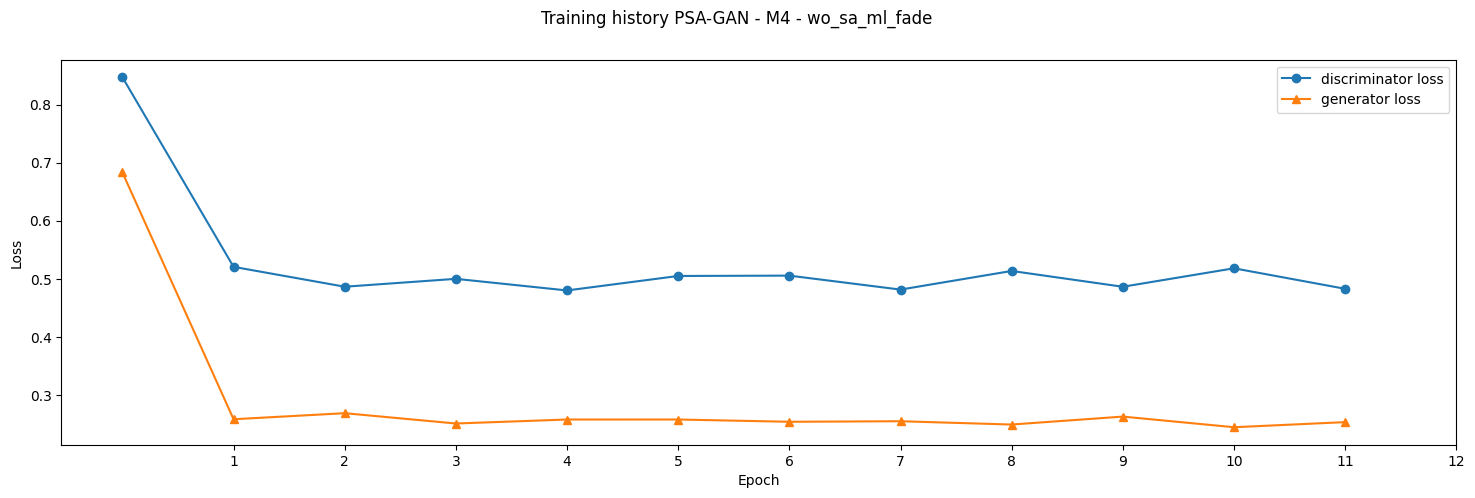

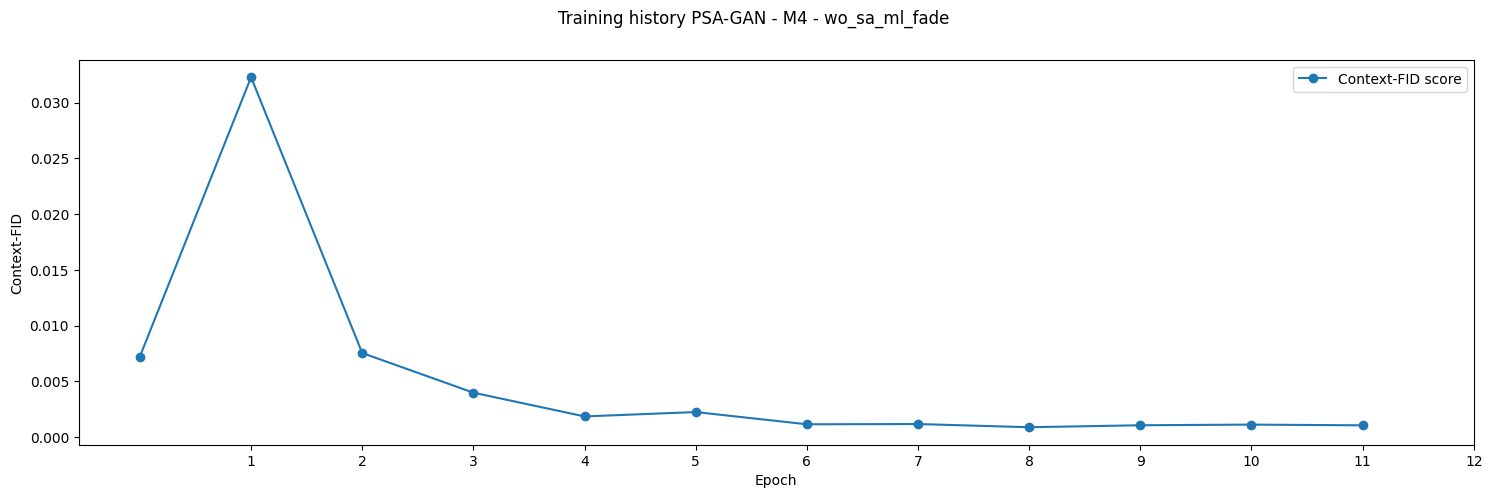

In [37]:
%%time

name_model="wo_sa_ml_fade"
D,G, d_losses, g_losses, fids = train.train_GAN(
    trainX,
    sequences_train,
    seq_length=seq_length,
    batch_size=347,
    discriminator_lr=0.0005,
    generator_lr=0.0005,
    num_epochs=12,
    blocks_to_add=2,
    timestamp=4,
    ml=False,
    fade_in=False,
    sa=False,
    save=True,
    name=name_model,
    gpu=True,
    path=path,
)

100%|██████████| 121/121 [00:02<00:00, 43.54it/s]


wo_sa_ml_fade  NRMSE: 0.8066661953926086


100%|██████████| 121/121 [00:49<00:00,  2.46it/s]

FID = 0.010765739889590946 +- 0.010765739889590946  
std: 0.0
NRMSE on test set:  tensor(110.0873)


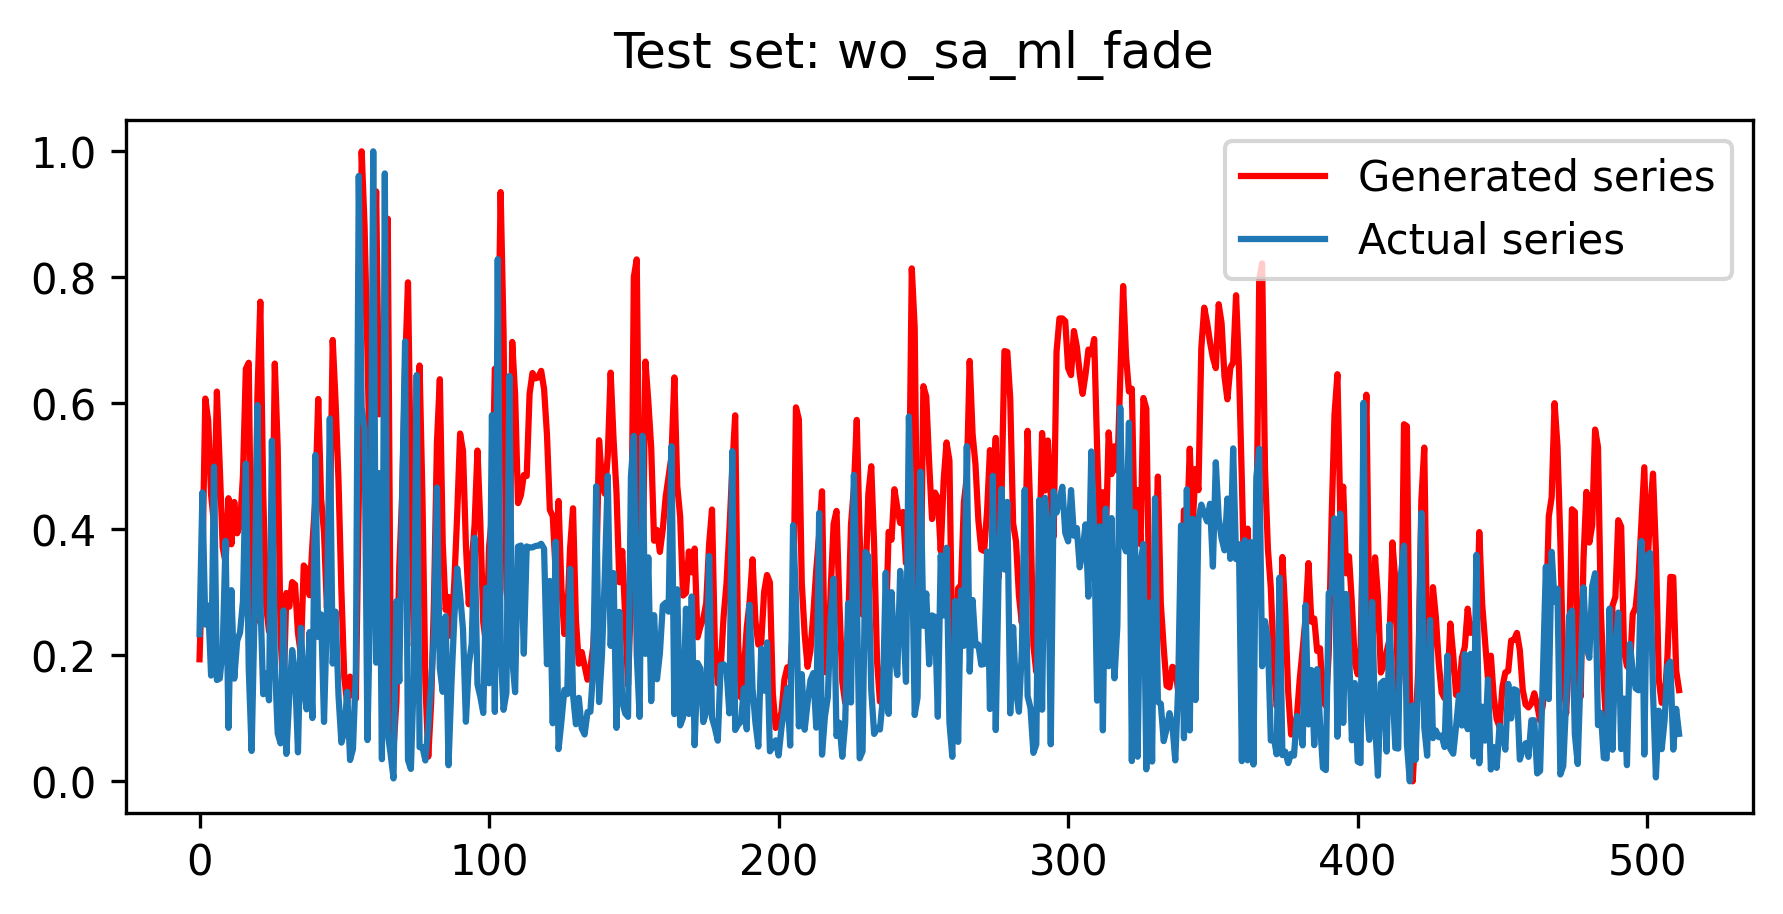

In [38]:
nrmse= metrics.evaluate_model(G,test_loader, "NRMSE")
print(name_model," NRMSE:",nrmse)

#mean, std_dev, lower, upper = metrics.run_evaluation(G,G,G, test_loader, "FID",0.95, embedder)
mean, std_dev, lower, upper = metrics.run_evaluation1(G, test_loader, "FID", 0.95, embedder)
print("FID =",mean,"+-",upper," \nstd:",std_dev)

plotting.prediction_test(seq_length, 347, test_set, testX, G, name_model)

In [39]:
utils.free_gpu(G)